In [6]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud

In [8]:
# file contains some invalid chars
# depending on which version of pandas you have
# an error may be thrown
df = pd.read_csv('../Datasets/spam.csv', encoding='ISO-8859-1')

In [10]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [12]:
# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [14]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [16]:
# rename columns to something better
df.columns = ['labels', 'data']

In [18]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<Axes: >

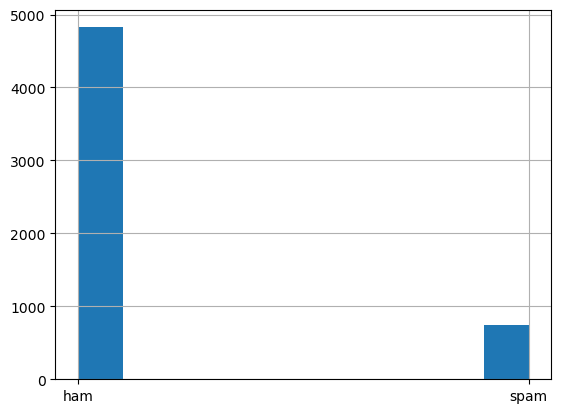

In [20]:
df['labels'].hist()

In [22]:
# create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].to_numpy()

In [24]:
# split up the data
df_train, df_test, Ytrain, Ytest = train_test_split(
    df['data'], Y, test_size=0.33)

In [26]:
# try multiple ways of calculating features
# featurizer = TfidfVectorizer(decode_error='ignore')
# Xtrain = featurizer.fit_transform(df_train)
# Xtest = featurizer.transform(df_test)

featurizer = CountVectorizer(decode_error='ignore')
Xtrain = featurizer.fit_transform(df_train)
Xtest = featurizer.transform(df_test)

In [30]:
Xtrain

<3733x6987 sparse matrix of type '<class 'numpy.int64'>'
	with 49728 stored elements in Compressed Sparse Row format>

In [32]:
# create the model, train it, print scores
model = MultinomialNB()
model.fit(Xtrain, Ytrain)
print("train acc:", model.score(Xtrain, Ytrain))
print("test acc:", model.score(Xtest, Ytest))

train acc: 0.993302973479775
test acc: 0.9858618814573138


In [34]:
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)
print("train F1:", f1_score(Ytrain, Ptrain))
print("test F1:", f1_score(Ytest, Ptest))

train F1: 0.9748743718592965
test F1: 0.9453781512605043


In [36]:
Prob_train = model.predict_proba(Xtrain)[:,1]
Prob_test = model.predict_proba(Xtest)[:,1]
print("train AUC:", roc_auc_score(Ytrain, Prob_train))
print("test AUC:", roc_auc_score(Ytest, Prob_test))

train AUC: 0.991759043263638
test AUC: 0.9862043270466109


In [38]:
cm = confusion_matrix(Ytrain, Ptrain)
cm

array([[3223,    7],
       [  18,  485]], dtype=int64)

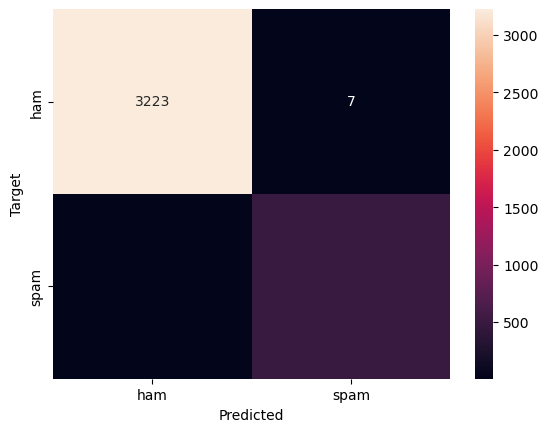

In [40]:
# Scikit-Learn is transitioning to V1 but it's not available on Colab
# The changes modify how confusion matrices are plotted
def plot_cm(cm):
  classes = ['ham', 'spam']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

plot_cm(cm)

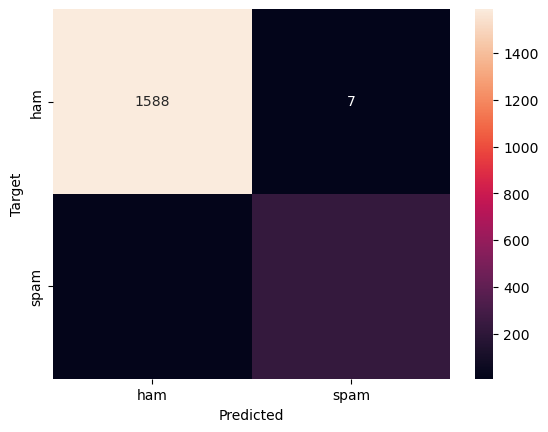

In [42]:
cm_test = confusion_matrix(Ytest, Ptest)
plot_cm(cm_test)

In [44]:
# visualize the data
def visualize(label):
  words = ''
  for msg in df[df['labels'] == label]['data']:
    msg = msg.lower()
    words += msg + ' '
  wordcloud = WordCloud(width=600, height=400).generate(words)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

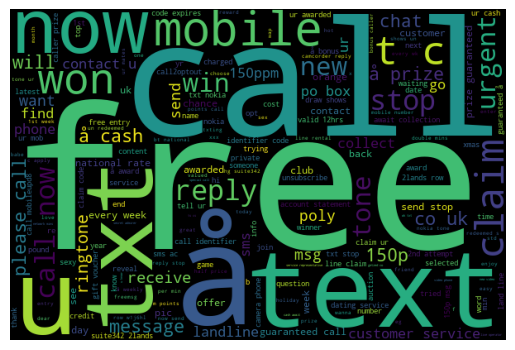

In [46]:
visualize('spam')

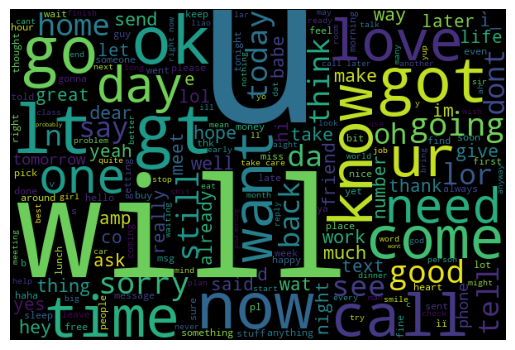

In [48]:
visualize('ham')

In [50]:
# see what we're getting wrong
X = featurizer.transform(df['data'])
df['predictions'] = model.predict(X)

In [52]:
# things that should be spam
sneaky_spam = df[(df['predictions'] == 0) & (df['b_labels'] == 1)]['data']
for msg in sneaky_spam:
  print(msg)

FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv
Did you hear about the new \Divorce Barbie\"? It comes with all of Ken's stuff!"
Email AlertFrom: Jeri StewartSize: 2KBSubject: Low-cost prescripiton drvgsTo listen to email call 123
Do you realize that in about 40 years, we'll have thousands of old ladies running around with tattoos?
Talk sexy!! Make new friends or fall in love in the worlds most discreet text dating service. Just text VIP to 83110 and see who you could meet.
Hello. We need some posh birds and chaps to user trial prods for champneys. Can i put you down? I need your address and dob asap. Ta r
Filthy stories and GIRLS waiting for your
Got what it takes 2 take part in the WRC Rally in Oz? U can with Lucozade Energy! Text RALLY LE to 61200 (25p), see packs or lucozade.co.uk/wrc & itcould be u!
Can U get 2 phone NOW? I wanna chat 2 set up meet Call me NOW on 09096102316 U can 

In [54]:
# things that should not be spam
# perhaps some are mislabeled?
not_actually_spam = df[(df['predictions'] == 1) & (df['b_labels'] == 0)]['data']
for msg in not_actually_spam:
  print(msg)

Yes:)from last week itself i'm taking live call.
Can u get pic msgs to your phone?
We have sent JD for Customer Service cum Accounts Executive to ur mail id, For details contact us
Hey...Great deal...Farm tour 9am to 5pm $95/pax, $50 deposit by 16 May
Yavnt tried yet and never played original either
Unlimited texts. Limited minutes.
Mathews or tait or edwards or anderson
Gettin rdy to ship comp
Have you laid your airtel line to rest?
I liked the new mobile
Anytime...
I (Career Tel) have added u as a contact on INDYAROCKS.COM to send FREE SMS. To remove from phonebook - sms NO to  &lt;#&gt;
Nokia phone is lovly..
We have sent JD for Customer Service cum Accounts Executive to ur mail id, For details contact us


In [56]:
# try multiple ways of calculating features
featurizer = TfidfVectorizer(decode_error='ignore')
Xtrain = featurizer.fit_transform(df_train)
Xtest = featurizer.transform(df_test)

In [58]:
Xtrain

<3733x6987 sparse matrix of type '<class 'numpy.float64'>'
	with 49728 stored elements in Compressed Sparse Row format>

In [60]:
# create the model, train it, print scores
model = MultinomialNB()
model.fit(Xtrain, Ytrain)
print("train acc:", model.score(Xtrain, Ytrain))
print("test acc:", model.score(Xtest, Ytest))

train acc: 0.9699973211893919
test acc: 0.9543230016313213


In [62]:
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)
print("train F1:", f1_score(Ytrain, Ptrain))
print("test F1:", f1_score(Ytest, Ptest))

train F1: 0.8747203579418344
test F1: 0.7920792079207921


In [64]:
Prob_train = model.predict_proba(Xtrain)[:,1]
Prob_test = model.predict_proba(Xtest)[:,1]
print("train AUC:", roc_auc_score(Ytrain, Prob_train))
print("test AUC:", roc_auc_score(Ytest, Prob_test))

train AUC: 0.9925087247413352
test AUC: 0.9867464926255204


In [66]:
cm = confusion_matrix(Ytrain, Ptrain)
cm

array([[3230,    0],
       [ 112,  391]], dtype=int64)

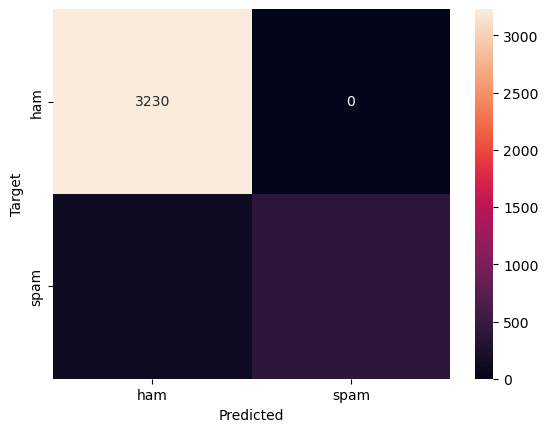

In [68]:
# Scikit-Learn is transitioning to V1 but it's not available on Colab
# The changes modify how confusion matrices are plotted
def plot_cm(cm):
  classes = ['ham', 'spam']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

plot_cm(cm)

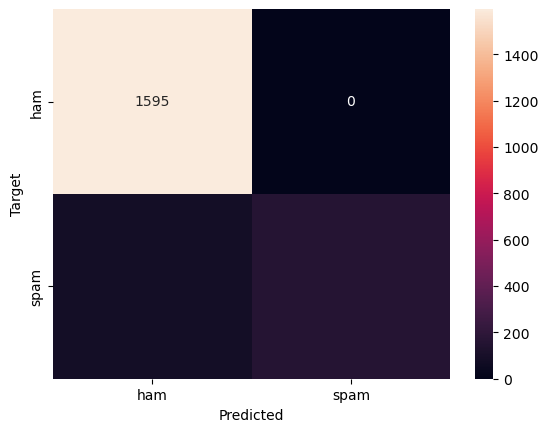

In [69]:
cm_test = confusion_matrix(Ytest, Ptest)
plot_cm(cm_test)

In [70]:
# visualize the data
def visualize(label):
  words = ''
  for msg in df[df['labels'] == label]['data']:
    msg = msg.lower()
    words += msg + ' '
  wordcloud = WordCloud(width=600, height=400).generate(words)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

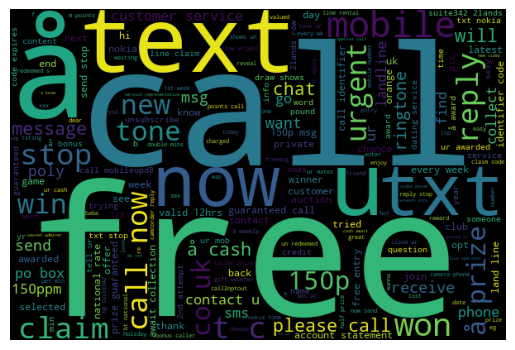

In [72]:
visualize('spam')

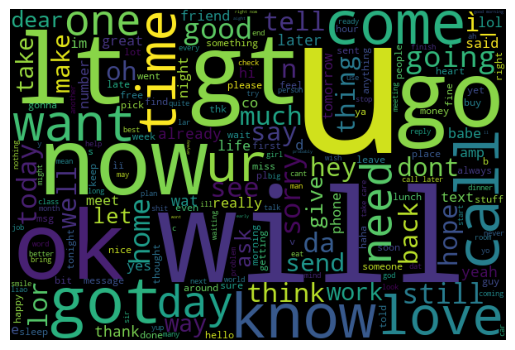

In [73]:
visualize('ham')

In [76]:
# see what we're getting wrong
X = featurizer.transform(df['data'])
df['predictions'] = model.predict(X)

In [77]:
# things that should be spam
sneaky_spam = df[(df['predictions'] == 0) & (df['b_labels'] == 1)]['data']
for msg in sneaky_spam:
  print(msg)

FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv
Thanks for your subscription to Ringtone UK your mobile will be charged å£5/month Please confirm by replying YES or NO. If you reply NO you will not be charged
Congrats! 1 year special cinema pass for 2 is yours. call 09061209465 now! C Suprman V, Matrix3, StarWars3, etc all 4 FREE! bx420-ip4-5we. 150pm. Dont miss out! 
Did you hear about the new \Divorce Barbie\"? It comes with all of Ken's stuff!"
Your free ringtone is waiting to be collected. Simply text the password \MIX\" to 85069 to verify. Get Usher and Britney. FML
You'll not rcv any more msgs from the chat svc. For FREE Hardcore services text GO to: 69988 If u get nothing u must Age Verify with yr network & try again
Customer service annoncement. You have a New Years delivery waiting for you. Please call 07046744435 now to arrange delivery
BangBabes Ur order is on the way. U SHOUL

In [78]:
# things that should not be spam
# perhaps some are mislabeled?
not_actually_spam = df[(df['predictions'] == 1) & (df['b_labels'] == 0)]['data']
for msg in not_actually_spam:
  print(msg)